<a href="https://colab.research.google.com/github/NiloofarSoltani-2/Smart-Water-Management/blob/main/smart_water_management.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.subplots as sp

# Introduction

## Data Structure

In [2]:
from google.colab import drive
drive.mount('/content/drive')


# Original shareable link
file_id = '1gP3ftPhvX58Xieve9tLR_OPX2D8Kc4lN'  # extract this from the URL
download_url = f'https://drive.google.com/uc?id={file_id}'
df = pd.read_csv(download_url)
df.shape

Mounted at /content/drive


(8154, 6)

In [3]:
df. columns

Index(['Mean_Rainfall', 'Mean_Temp', 'Actual_Depth', 'Actual_Volume',
       'Actual_Hydrometry', 'Date'],
      dtype='object')

In [4]:
df.isnull().sum()

,0
Mean_Rainfall,0
Mean_Temp,0
Actual_Depth,0
Actual_Volume,0
Actual_Hydrometry,0
Date,0


## Cleaning


*   Missing Values = 0
*   Duplicate Values = 0
*   Convert Date Format (Indexing)
*   Time Frequency Consistency



In [5]:
df.columns = df.columns.str.lower()
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

In [6]:
df. columns

Index(['mean_rainfall', 'mean_temp', 'actual_depth', 'actual_volume',
       'actual_hydrometry'],
      dtype='object')

In [7]:
df.index.to_series().diff().value_counts()

,count
date,
1 days,8131
3 days,8
7 days,6
26 days,3
25 days,2
4 days,1
23 days,1
20 days,1


8131 records occur at exactly 1-day intervals ==> dataset is primarily daily

Total anomalies: 23 rows

    Risk for Model Accuracy

    Models like ARIMA, Prophet, LSTM require uniform time intervals

    Gaps can lead to:

    Distorted trend/seasonality analysis

    Reduced prediction accuracy

    Misleading results if left uncorrected




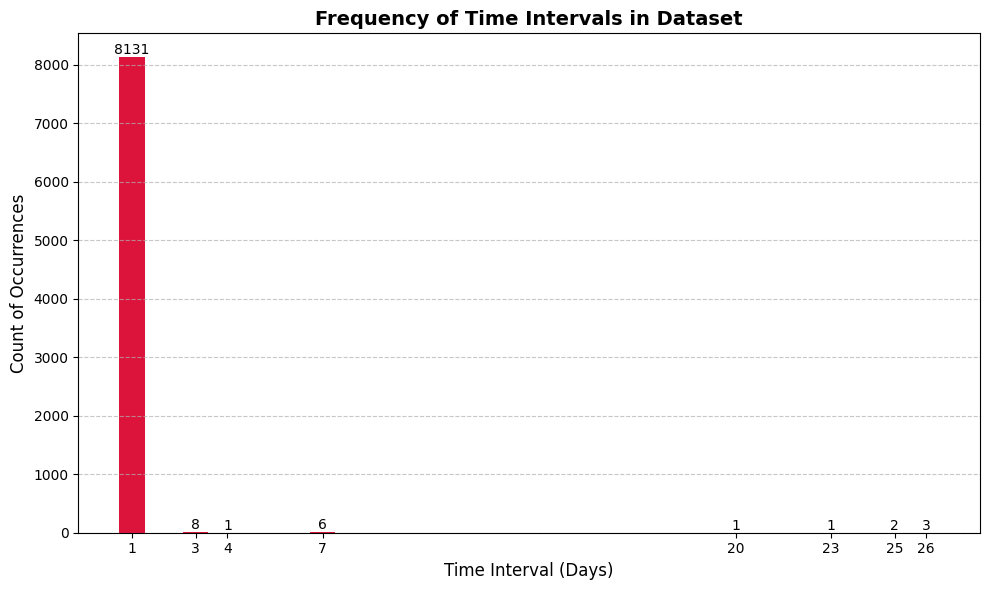

In [8]:
time_deltas = df.index.to_series().diff().value_counts().sort_index()
delta_days = time_deltas.index.days
counts = time_deltas.values

plt.figure(figsize=(10, 6))
bars = plt.bar(delta_days, counts, color='crimson')
plt.title('Frequency of Time Intervals in Dataset', fontsize=14, weight='bold')
plt.xlabel('Time Interval (Days)', fontsize=12)
plt.ylabel('Count of Occurrences', fontsize=12)
plt.xticks(delta_days)

for i in range(len(delta_days)):
    plt.text(delta_days[i], counts[i] + 0.5, str(counts[i]),
             ha='center', va='bottom', fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# EDA

EDA helps you understand data structure, patterns, anomalies, and relationships before modeling.

| Step                         | Purpose                                | Example Tools               |
| ---------------------------- | -------------------------------------- | --------------------------- |
| 1. **Data Overview**         | Check shape, dtypes, nulls, duplicates | `.info()`, `.describe()`    |
| 2. **Datetime Conversion**   | Ensure `Date` is `datetime` & indexed  | `pd.to_datetime()`          |
| 3. **Frequency Check**       | Identify daily/weekly data and gaps    | `.diff().value_counts()`    |
| 4. **Missing Values**        | Detect & impute missing data           | `.isna()`, `.interpolate()` |
| 5. **Trend Visualization**   | Check for overall movement             | `plt.plot()`, `rolling()`   |
| 6. **Seasonality Detection** | Daily/weekly/monthly cycles?           | `seasonal_decompose()`      |
| 7. **Outlier Detection**     | Find spikes or errors                  | `z-score`, boxplots         |
| 8. **Correlation Analysis**  | Input/output dependencies              | `.corr()`, heatmaps         |
| 9. **Distribution Analysis** | Understand value ranges                | `histplot`, KDE             |
| 10. **Stationarity Test**    | Needed for ARIMA, not LSTM             | ADF/KPSS test               |




---


### **EDA for LSTM**
LSTM still needs:

*   Clean and gap-free sequences

*   Understanding of seasonality and trends

*   Detection and handling of outliers

*   Multivariate dependencies (e.g., rainfall affects depth)


---




| Feature        | Traditional Time Series                  | LSTM Focus                                       |
| -------------- | ---------------------------------------- | ------------------------------------------------ |
| Stationarity   | **Important** (ARIMA, ETS)               | ❌ Not required                                   |
| Differencing   | Often applied                            | Optional                                         |
| Scaling        | Optional                                 | **Required**                                     |
| Sequence shape | 1D (univariate) or lagged DF             | 3D shape: (samples, timesteps, features)         |
| Visual goal    | Check seasonality/trend for model choice | Check to decide **sequence length** and features |

---


## Missing Values

In [9]:
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]
print(missing_values)

Series([], dtype: int64)


## Duplicate Values

In [10]:
print("Total duplicate rows:", df.duplicated().sum())

Total duplicate rows: 0


## Feature Relevance


*   Correlation Analysis(Basic)
*   Visual Inspection
*   Lagged Correlation
*   Statistical Tests(Advanced) {

        *    Granger Causality Test [	Does X help predict Y? (Time series)]
        *    Mutual Information [Measures nonlinear relationships]
        *    Feature Importance (RF, XGBoost) [Ranks influence using models]
}



---



| Method                 | When to Use         | Result Type        |
| ---------------------- | ------------------- | ------------------ |
| `.corr()`              | First-pass check    | Linear strength    |
| Overlay / Scatter plot | Visual confirmation | Relationship shape |
| `.shift()` + `.corr()` | For delayed effects | Lag-based insights |
| ML Feature Importance  | Model-driven        | Ranked influence   |
| Granger causality      | Statistical proof   | Causal indication  |




---




### Correlation Analysis

Range: -1 (perfect negative) → 0 (no correlation) → +1 (perfect positive)

| Value     | Meaning                     |
| --------- | --------------------------- |
| > 0.7     | Strong positive relation    |
| 0.3 – 0.7 | Moderate                    |
| 0 – 0.3   | Weak                        |
| < 0       | Negative relation (inverse) |


In [11]:
# Pearson correlation score between actual_depth and every other numeric column
df.corr()['actual_depth'].sort_values()

,actual_depth
actual_hydrometry,-0.515571
mean_temp,-0.254497
mean_rainfall,0.016298
actual_volume,0.337452
actual_depth,1.000000


### Visual Inspection

If two time series go up and down together, or when one rises and the other falls, you may have influence.



<Axes: xlabel='date'>

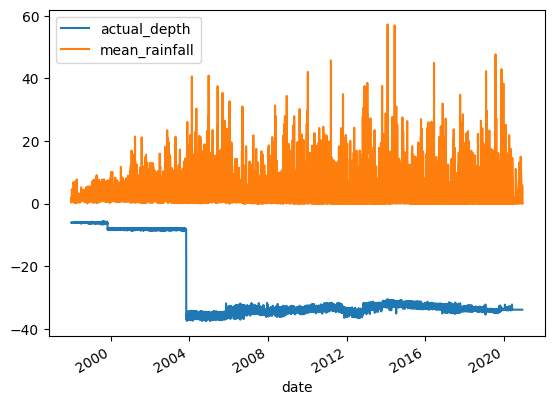

In [12]:
df[['actual_depth', 'mean_rainfall']].plot()

If the points form a pattern (not random cloud), it shows relation.

<Axes: xlabel='mean_rainfall', ylabel='actual_depth'>

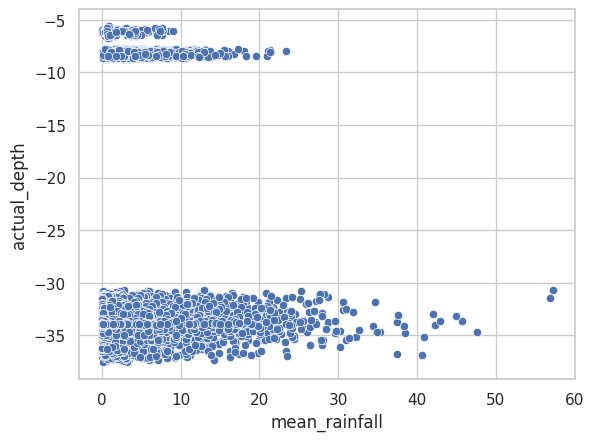

In [ ]:
sns.scatterplot(data=df, x='mean_rainfall', y='actual_depth')

### Lagged Correlation (Influence with Delay)

Sometimes rainfall doesn’t affect depth immediately, but after a delay (e.g., water needs time to seep in).

You can test it like this:


🔁 Try .shift(7), .shift(14), .shift(90) to see where the best correlation appears.

In [ ]:

df['rain_lag_30'] = df['mean_rainfall'].shift(30)
df[['actual_depth', 'rain_lag_30']].dropna().corr()

### Statistical Tests (Advanced)

#### Granger Causality Test

#### Mutual Information

#### Feature Importance (RF, XGBoost)

### Trend Analysis

In [ ]:
columns = ['mean_rainfall', 'mean_temp', 'actual_depth', 'actual_volume','actual_hydrometry']
df_selected = df[columns].dropna(how='all')

# Create subplots
fig = sp.make_subplots(
    rows=len(columns), cols=1, shared_xaxes=True, vertical_spacing=0.03,
    subplot_titles=[col.replace('_', ' ').title() for col in columns]
)

# Add each column to its subplot
for i, col in enumerate(columns, start=1):
    fig.add_trace(
        go.Scatter(x=df_selected.index, y=df_selected[col], mode='lines', name=col),
        row=i, col=1
    )

# Update layout
fig.update_layout(
    height=250 * len(columns),
    title_text='Aquifer Variables Over Time (Interactive)',
    template='plotly_white',
    hovermode='x unified',
    showlegend=False
)

fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Value')

fig.show()


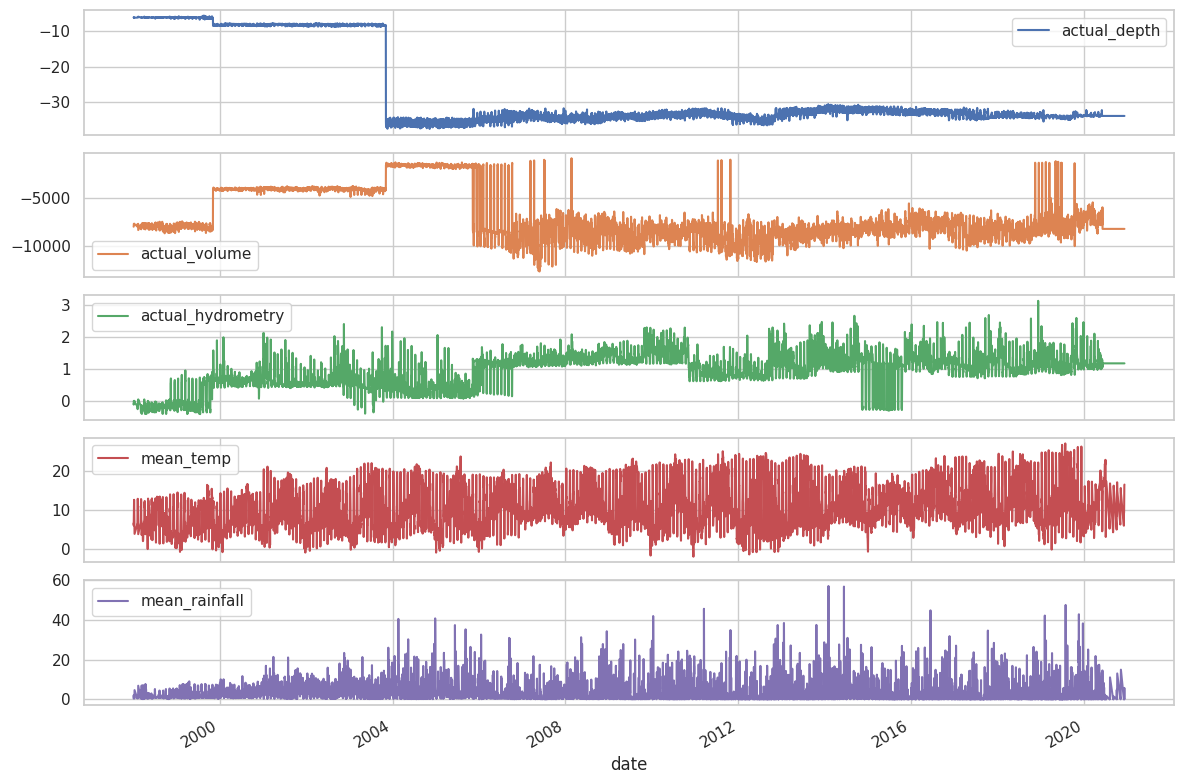

In [ ]:
df[['actual_depth', 'actual_volume', 'actual_hydrometry','mean_temp','mean_rainfall']].plot(subplots=True, figsize=(12, 8))
plt.tight_layout()
plt.show()


#### rolling average if data has outlier to remove them to prepare suitable entry for lstm model

In [ ]:
df['depth_rolling'] = df['actual_depth'].rolling(window=90).mean()
print (df['depth_rolling'])

date
2022-01-01      NaN
2022-01-02      NaN
2022-01-03      NaN
2022-01-04      NaN
2022-01-05      NaN
              ...  
2022-10-23    15.01
2022-10-24    15.03
2022-10-25    15.05
2022-10-26    15.07
2022-10-27    15.09
Freq: D, Name: depth_rolling, Length: 300, dtype: float64


In [ ]:
# Compute 90-day rolling average
df['rolling_depth'] = df['actual_depth'].rolling(window=90).mean()
df_clean = df.dropna(subset=['rolling_depth'])

# Convert index to Series for shaded area
index_series = pd.Series(df_clean.index)

# Create interactive plot
fig = go.Figure()

# Actual Depth line
fig.add_trace(go.Scatter(
    x=df.index,
    y=df['actual_depth'],
    mode='lines',
    name='Actual Depth (Daily)',
    line=dict(color='steelblue', width=1),
    opacity=0.4
))

# Rolling Mean line
fig.add_trace(go.Scatter(
    x=df_clean.index,
    y=df_clean['rolling_depth'],
    mode='lines',
    name='90-Day Rolling Mean',
    line=dict(color='crimson', width=3)
))

# Shaded area under rolling mean
fig.add_trace(go.Scatter(
    x=pd.concat([index_series, index_series[::-1]]),
    y=pd.concat([df_clean['rolling_depth'], pd.Series([0]*len(df_clean))]),
    fill='toself',
    fillcolor='rgba(220, 20, 60, 0.1)',
    line=dict(color='rgba(255,255,255,0)'),
    hoverinfo="skip",
    name='Shaded Area'
))

# Start and End markers
fig.add_trace(go.Scatter(
    x=[df.index[0]],
    y=[df['actual_depth'].iloc[0]],
    mode='markers',
    marker=dict(size=10, color='blue'),
    name='Start Point'
))
fig.add_trace(go.Scatter(
    x=[df.index[-1]],
    y=[df['actual_depth'].iloc[-1]],
    mode='markers',
    marker=dict(size=10, color='blue'),
    name='End Point'
))

# Vertical line and annotation
highlight_date = df_clean.index[0]
highlight_value = df_clean['rolling_depth'].iloc[0]
fig.add_shape(type="line", x0=highlight_date, x1=highlight_date,
              y0=df['actual_depth'].min(), y1=df['actual_depth'].max(),
              line=dict(color="gray", dash="dash"))
fig.add_annotation(x=highlight_date, y=highlight_value + 1,
                   text="Start of Trend", showarrow=True, arrowhead=1)

# Layout customization
fig.update_layout(
    title='Interactive Groundwater Depth Trend (Smoothed vs. Daily)',
    xaxis_title='Date',
    yaxis_title='Actual Depth (m)',
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
    template='plotly_white',
    height=600
)

fig.show()


<Axes: xlabel='date'>

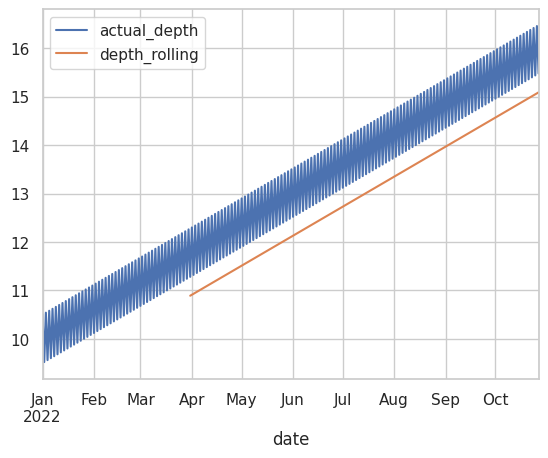

In [ ]:
df[['actual_depth','depth_rolling']].plot()


In [ ]:
df.columns

Index(['actual_depth', 'depth_rolling', 'rolling_depth'], dtype='object')

In [ ]:
df.corr()['actual_depth'].sort_values()
